# 이커머스 RFM 데이터를 활용한 고객군 clustering

## 01. 데이터 소개 및 분석프로세스 수립

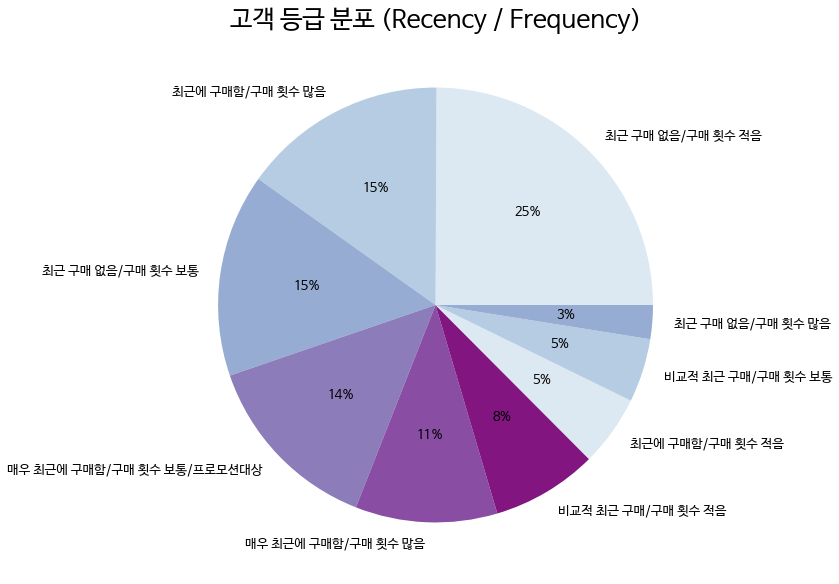

지난 프로젝트에서 얻은 **RFM** 분석 지표 중 `Recency`와 `Frequency`를 활용해 분류한 고객군은 분포는 위 그래프와 같습니다.

- Recency: 고객이 최근에 구입을 했는가?

- Frequency: 고객이 얼마나 빈번하게 상품을 구입했는가?

- Monetary: 고객이 구입했던 총 금액은 얼마인가?

이번 프로젝트에서는 해당 **RFM** 지표 전체를 활용해 

**고객군 clustering**을 진행해 보고 각 고객층에 맞는 **의사결정**을 내려보겠습니다.


## 02. 데이터 탐색 및 전처리

### 0. 데이터 불러오기

* matplotlib 한글 깨짐 현상 해결
> 셀 실행 후 런타임 재시작 필요

In [1]:
# 한글 깨짐 현상 해결
# !apt-get update -qq
# !apt-get install fonts-nanum* -qq

# import matplotlib.font_manager as fm
# from matplotlib import pyplot as plt

# path = '/usr/share/fonts/truetype/nanum/NanumGothicEco.ttf'
# font_name = fm.FontProperties(fname=path, size=10).get_name()

# plt.rc('font', family=font_name)

# fm._rebuild()

In [ ]:
!pip install chart_studio

In [30]:
############################################## 00. 필요한 파이썬 라이브러리 불러오기 #####################################################
import pandas as pd
import numpy as np 
import seaborn as sns

from itertools import combinations

from matplotlib import pyplot as plt
import matplotlib as mpl
plt.rc('font', family='NanumBarunGothic') 

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from yellowbrick.cluster import SilhouetteVisualizer

import plotly.express as px
import chart_studio
import chart_studio.plotly as py
import chart_studio.tools as tls
import plotly.graph_objects as go
import plotly.io as pio

import warnings
warnings.filterwarnings('ignore')

In [4]:
from google.colab import drive

drive.mount('/content/MyDrive')

Drive already mounted at /content/MyDrive; to attempt to forcibly remount, call drive.mount("/content/MyDrive", force_remount=True).


In [5]:
df = pd.read_csv('/content/MyDrive/MyDrive/transactions.csv')
df.head()

,CustomerID,Recency,Frequency,Monetary,R,F,M,RFM score,Segment
0,15531,7,219,1972.39,5,5,5,555,매우 최근에 구매함/구매 횟수 많음
1,17861,2,219,2056.28,5,5,5,555,매우 최근에 구매함/구매 횟수 많음
2,15351,11,219,1866.21,5,5,5,555,매우 최근에 구매함/구매 횟수 많음
3,17673,1,218,1588.07,5,5,5,555,매우 최근에 구매함/구매 횟수 많음
4,13527,33,217,2218.61,4,5,5,455,최근에 구매함/구매 횟수 많음


### 데이터 탐색 및 전처리

In [6]:
# 데이터 형태
df.shape

(3608, 9)

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3608 entries, 0 to 3607
Data columns (total 9 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   CustomerID  3608 non-null   int64  
 1   Recency     3608 non-null   int64  
 2   Frequency   3608 non-null   int64  
 3   Monetary    3608 non-null   float64
 4   R           3608 non-null   int64  
 5   F           3608 non-null   int64  
 6   M           3608 non-null   int64  
 7   RFM score   3608 non-null   int64  
 8   Segment     3608 non-null   object 
dtypes: float64(1), int64(7), object(1)
memory usage: 253.8+ KB


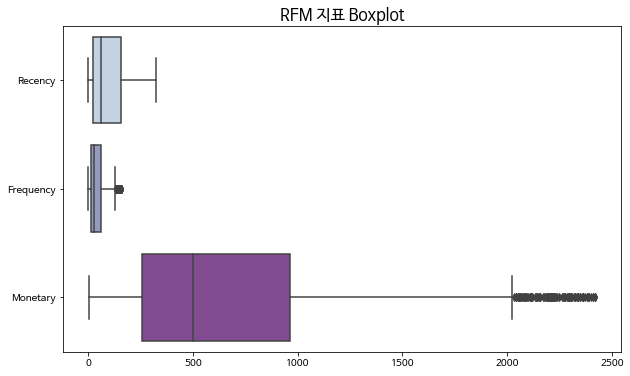

In [31]:
features = ['Recency', 'Frequency', 'Monetary']

plt.figure(figsize=(10, 6))
sns.boxplot(data = df[features], orient='h', palette='BuPu')
plt.title('RFM 지표 Boxplot', fontsize=16)
plt.show()

In [9]:
from collections import Counter

def detect_outliers(df, features):
    outlier_indices = []

    for col in features:
        # 1st quartile (25%)
        Q1 = np.percentile(df[col], 25)
        # 3rd quartile (75%)
        Q3 = np.percentile(df[col], 75)
        # Interquartile range (IQR)
        
        IQR = Q3 - Q1

        # outlier step
        upperfence = Q3 + (1.5 * IQR)
        lowerfence = Q1 - (1.5 * IQR)

        # 이상치 컬럼 리스트
        outlier_list_col = df[(df[col] < lowerfence) | (df[col] > upperfence)].index
        outlier_indices.extend(outlier_list_col)

    outlier_indices = Counter(outlier_indices)        
    return outlier_indices

feat = ['Recency', 'Frequency', 'Monetary']

Outliers_to_drop = detect_outliers(df, feat)

print(len(Outliers_to_drop))

311


In [10]:
df = df.drop(Outliers_to_drop)
df.shape

(3297, 9)

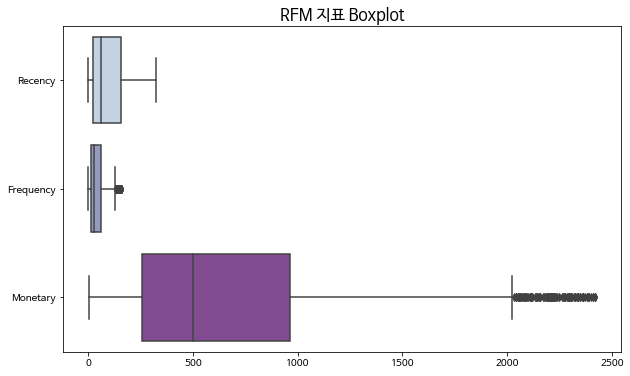

In [32]:
features = ['Recency', 'Frequency', 'Monetary']

plt.figure(figsize=(10, 6))
sns.boxplot(data = df[features], orient='h', palette='BuPu')
plt.title('RFM 지표 Boxplot', fontsize=16)
plt.show()

지난 프로젝트에서 전처리를 마친 데이터 셋이므로 학습 전  Outlier 제거 이외 다른 전처리를 진행하지 않겠습니다.

## K-Means Clustering 을 활용한 고객군 분류

In [12]:
model_df = df[['Recency', 'Frequency', 'Monetary']].copy().reset_index(drop=True)
model_df.head()

,Recency,Frequency,Monetary
0,34,158,557.94
1,11,158,900.53
2,28,157,741.37
3,40,157,701.57
4,25,157,501.03


`feature`간 스케일이 다르기 때문에 `StandardScaler`를 활용해
 각 지표의 표준화를 진행하겠습니다.

In [33]:
scaler = StandardScaler()

scaler.fit(model_df)

model_df_scaled = pd.DataFrame(scaler.transform(model_df), columns = ['Recency', 'Frequency', 'Monetary'])
model_df_scaled.head()

,Recency,Frequency,Monetary
0,-0.678080,3.234953,-0.222444
1,-0.931078,3.234953,0.391003
2,-0.744079,3.207007,0.106008
3,-0.612080,3.207007,0.034742
4,-0.777079,3.207007,-0.324348


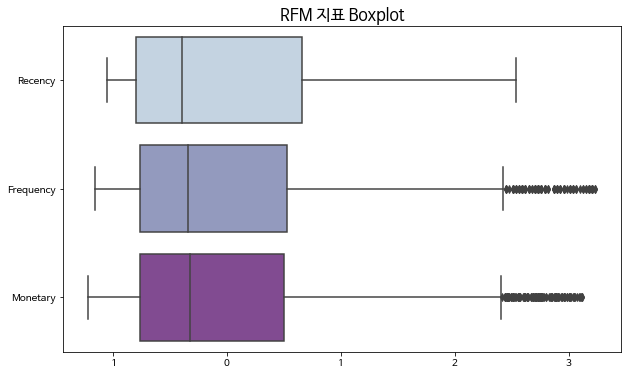

In [34]:
plt.figure(figsize=(10, 6))
sns.boxplot(data = model_df_scaled, orient='h', palette='BuPu')
plt.title('RFM 지표 Boxplot', fontsize=16)
plt.show()

### Elbow Method

**엘보우 기법**은 Cluster 간 거리 제곱 합의 총합 **(Total within cluster sum of squares)** 의 그래프가 팔꿈치처럼 꺾이는 지점을 최적의 군집 개수로 정하는 기법입니다.

다른 말로 **Cluster** 개수를 늘렸을 때 **Centroid 간의 평균 거리**가 더 이상 많이 감소하지 않는 경우의 K를 선택하는 기법입니다.

In [35]:
wcss = []
for i in range(2, 10):
  kmeans = KMeans(init='k-means++', n_clusters = i, n_init=10)
  kmeans.fit(model_df_scaled)
  wcss.append(kmeans.inertia_)
  print('k :', i, 'inertia :', round(kmeans.inertia_,2))  

k : 2 inertia : 5650.0
k : 3 inertia : 3543.44
k : 4 inertia : 2861.44
k : 5 inertia : 2361.7
k : 6 inertia : 2111.58
k : 7 inertia : 1886.43
k : 8 inertia : 1673.83
k : 9 inertia : 1522.67


Text(0.5, 1.0, 'Elbow method')

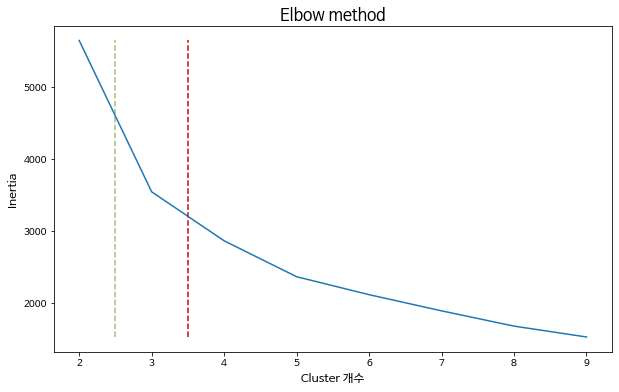

In [36]:
plt.figure(figsize=(10, 6))
sns.lineplot(x = range(2,10), y = wcss)
plt.vlines(2.5, ymin = np.array(wcss).min(), ymax = np.array(wcss).max(), linestyles='--', colors='g')
plt.vlines(3.5, ymin = np.array(wcss).min(), ymax = np.array(wcss).max(), linestyles='--', colors='r')
plt.xlabel('Cluster 개수', fontsize=12)
plt.ylabel('Inertia', fontsize=12)
plt.title('Elbow method', fontsize=16)

**Elbow method**를 통해 최적의 클러스터 개수를 구하면 3개가 이상적으로 보입니다.

### Silhouette method

**실루엣 지수**는 각 데이터별로 **해당 데이터가 속한 cluster** 내의 유사도와 **인접한 cluster**의 유사도를 비교하는 지표입니다.

 지수가 1에 가까울 수록 군집화가 잘 되었다는 의미입니다.

In [37]:
best_n = -1
best_silhouette_score = -1
silhouette_scores = []

for n_clusters in range(2, 10):
    kmeans = KMeans(init='k-means++', n_clusters = n_clusters, n_init=10)
    kmeans.fit(model_df_scaled)
    clusters = kmeans.predict(model_df_scaled)
    
    score = round(silhouette_score(model_df_scaled, clusters),4)
    silhouette_scores.append(score)
    print('k :', n_clusters, 'score :', score)

    if score > best_silhouette_score:
      best_n = n_clusters
      best_silhouette_score = score

print('='*30)
print('best n :', best_n, '\nbest score :', best_silhouette_score)

k : 2 score : 0.4046
k : 3 score : 0.4207
k : 4 score : 0.375
k : 5 score : 0.4022
k : 6 score : 0.3512
k : 7 score : 0.3377
k : 8 score : 0.3299
k : 9 score : 0.3319
best n : 3 
best score : 0.4207


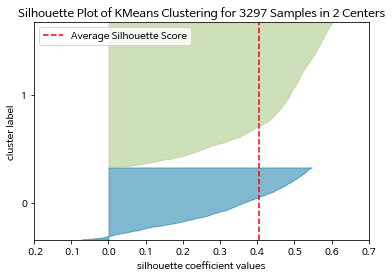

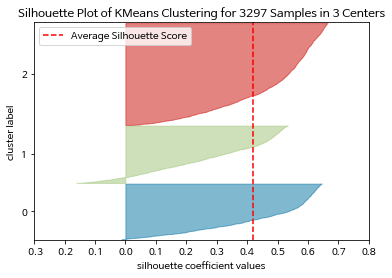

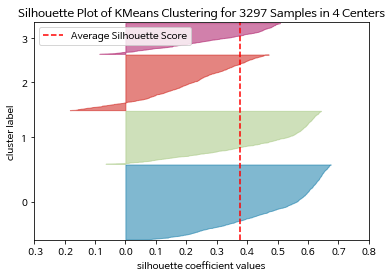

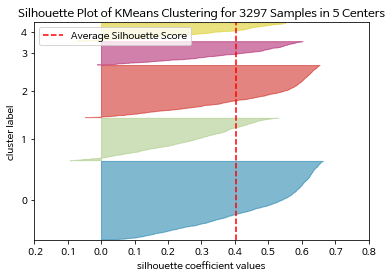

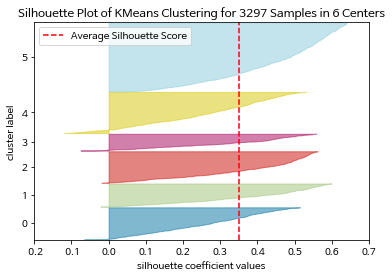

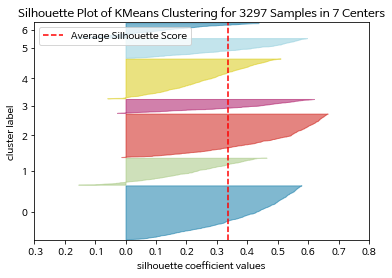

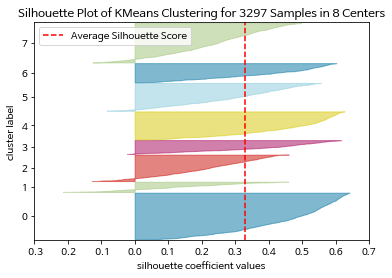

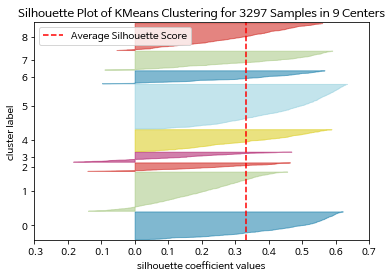

In [38]:
for n_clusters in range(2, 10):
    kmeans = KMeans(init='k-means++', n_clusters = n_clusters, n_init=10)
    kmeans.fit(model_df_scaled)
    visualizer = SilhouetteVisualizer(kmeans, colors='yellowbrick')
    visualizer.fit(model_df_scaled)
    visualizer.show()

**Silhouette method**를 통해 최적의 클러스터 개수를 구한 경우에도 3개가 이상적으로 보입니다.

In [67]:
kmeans = KMeans(init='k-means++', n_clusters = 3, n_init=10)

kmeans.fit(model_df_scaled)

KMeans(n_clusters=3)

군집화된 결과를 기존의 데이터 프레임에 합쳐주겠습니다.

In [68]:
model_df_scaled['Cluster'] = kmeans.labels_
model_df_scaled.head()

,Recency,Frequency,Monetary,Cluster
0,-0.678080,3.234953,-0.222444,0
1,-0.931078,3.234953,0.391003,0
2,-0.744079,3.207007,0.106008,0
3,-0.612080,3.207007,0.034742,0
4,-0.777079,3.207007,-0.324348,0


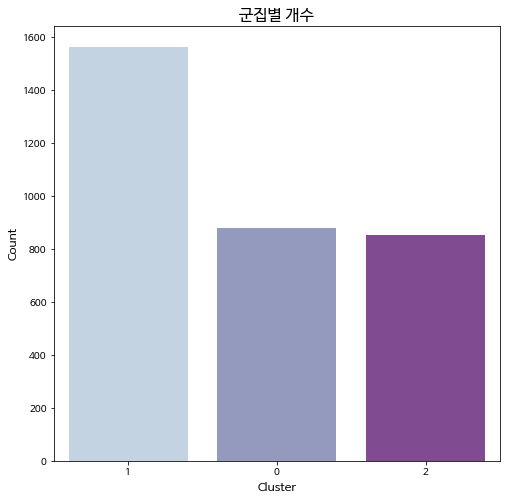

In [69]:
plt.figure(figsize=(8, 8))
sns.countplot(model_df_scaled['Cluster'], palette='BuPu', order=model_df_scaled['Cluster'].value_counts().index)
plt.xlabel('Cluster', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.title('군집별 개수', fontsize=16)
plt.show()

## Cluster 별 특징

3가지 군집으로 나눠진 고객층의 특징을 확인해보겠습니다.

- Recency: 고객이 최근에 구입을 했는가?

- Frequency: 고객이 얼마나 빈번하게 상품을 구입했는가?

- Monetary: 고객이 구입했던 총 금액은 얼마인가?

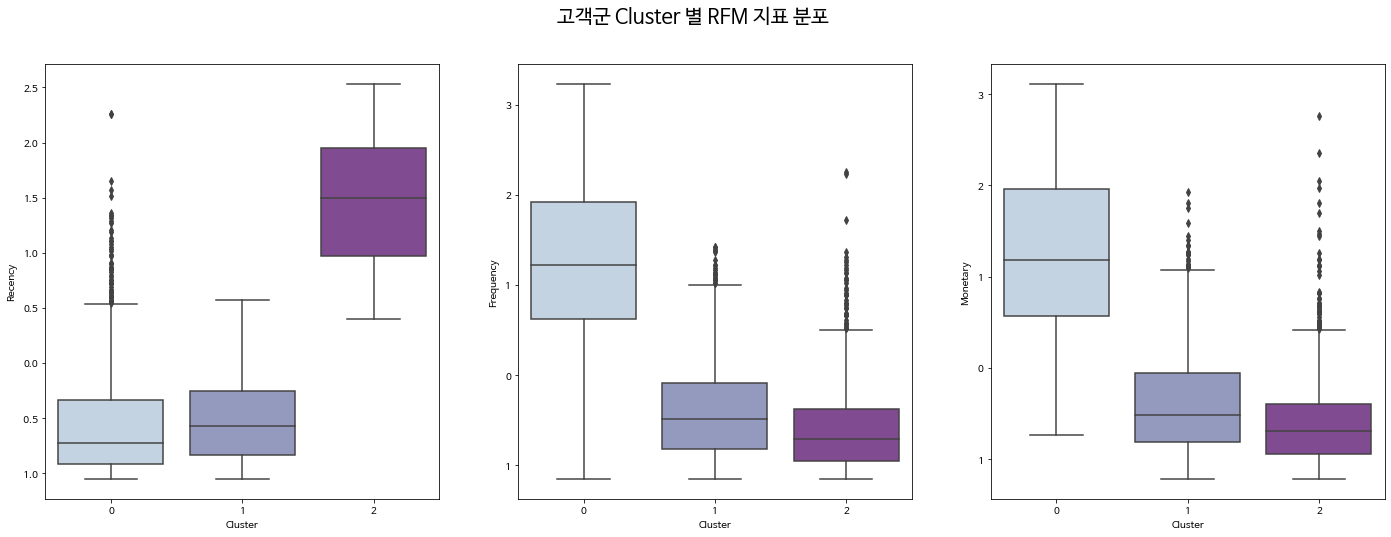

In [70]:
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(24, 8))

features = ['Recency', 'Frequency', 'Monetary']

for idx, feature in enumerate(features):
  sns.boxplot(x = 'Cluster', y = feature, data=model_df_scaled, ax=axes[idx], palette='BuPu')

plt.suptitle('고객군 Cluster 별 RFM 지표 분포', fontsize=20)
plt.show()

`Recency` 기준으로 볼 경우 **Cluster 2** 그룹의 점수가 타 Cluster에 비해 월등히 높은 것을 알 수 있습니다.

`Frequency` 기준으로 볼 경우 **Cluster 0** 그룹의 점수가 타 Cluster에 비해 높은 것을 알 수 있습니다.

마지막으로 `Monetary` 기준으로 볼 경우 **Cluster 0** 그룹의 점수가 타 Cluster에 비해 높은 것을 알 수 있습니다.

-----

다음은 **두 지표의 조합**에 따른 **고객 Cluster의 분포**를 확인해 보겠습니다.



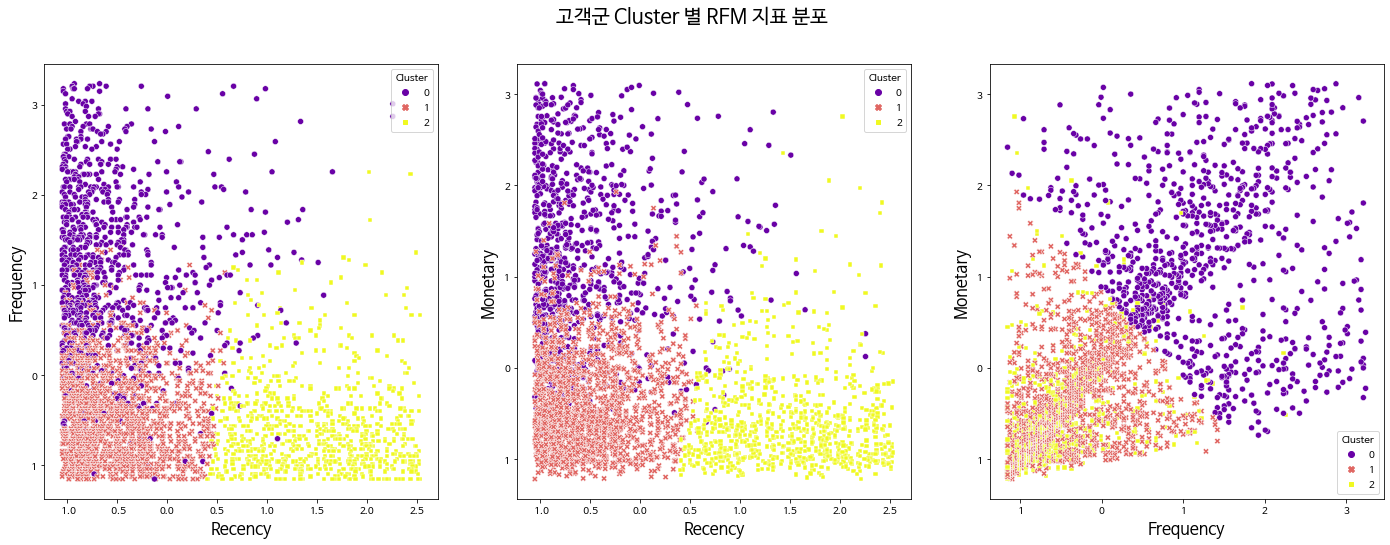

In [71]:
features = ['Recency', 'Frequency', 'Monetary']
combs = list(combinations(features, 2))

custom_palette = {0: '#6901A6',
                  1: '#E06561',
                  2: '#F0F921'}

orderhue= [0,1,2]


fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(24, 8))

for idx, comb in enumerate(combs):
  sns.scatterplot(x = comb[0], y = comb[1], data = model_df_scaled, hue = 'Cluster', style= 'Cluster', palette = custom_palette, hue_order= orderhue, ax=axes[idx])
  axes[idx].set_xlabel(str(comb[0]), fontsize = 16) 
  axes[idx].set_ylabel(str(comb[1]), fontsize = 16)

plt.suptitle('고객군 Cluster 별 RFM 지표 분포', fontsize=20)
plt.show()

`Cluster 0` 고객층은 **Recency**의 점수가 낮으나, **Frequency**, **Monetary**  점수는 타 그룹에 비해 골고루 분포되어 있음을 알 수 있습니다.

즉 과거에는 우리 서비스를 자주 애용했으나, 비교적 최근 구매 이력이 없는 고객층을 의미합니다.

----

`Cluster 1` 고객층은 **RFM** 지표의 점수가 상대적으로 모두 낮은 고객층입니다.

`Cluster 1` 그룹에 속한 고객의 대다수는 최근 구매 이력이 없으며, 구매 빈도수와 총 지출 모두 많이 적습니다.

----

`Cluster 2` 고객층은 전반적으로 **최근 구매 이력**이 있는 고객층입니다.

`Cluster 2` 그룹에 속한 고객의 대다수는 신규 고객이거나, 휴면 상태에서 복귀해 우리 서비스를 이용하고 있는 고객층을 의미합니다.

> Cluster 별 특징을 쉽게 확인하기 위해 3D 그래프로 시각화 해보겠습니다.

In [72]:
cluster_0_recency = model_df_scaled[model_df_scaled['Cluster'] == 0]['Recency'].tolist()
cluster_0_frequency = model_df_scaled[model_df_scaled['Cluster'] == 0]['Frequency'].tolist()
cluster_0_monetary = model_df_scaled[model_df_scaled['Cluster'] == 0]['Monetary'].tolist()

cluster_1_recency = model_df_scaled[model_df_scaled['Cluster'] == 1]['Recency'].tolist()
cluster_1_frequency = model_df_scaled[model_df_scaled['Cluster'] == 1]['Frequency'].tolist()
cluster_1_monetary = model_df_scaled[model_df_scaled['Cluster'] == 1]['Monetary'].tolist()

cluster_2_recency = model_df_scaled[model_df_scaled['Cluster'] == 2]['Recency'].tolist()
cluster_2_frequency = model_df_scaled[model_df_scaled['Cluster'] == 2]['Frequency'].tolist()
cluster_2_monetary = model_df_scaled[model_df_scaled['Cluster'] == 2]['Monetary'].tolist()

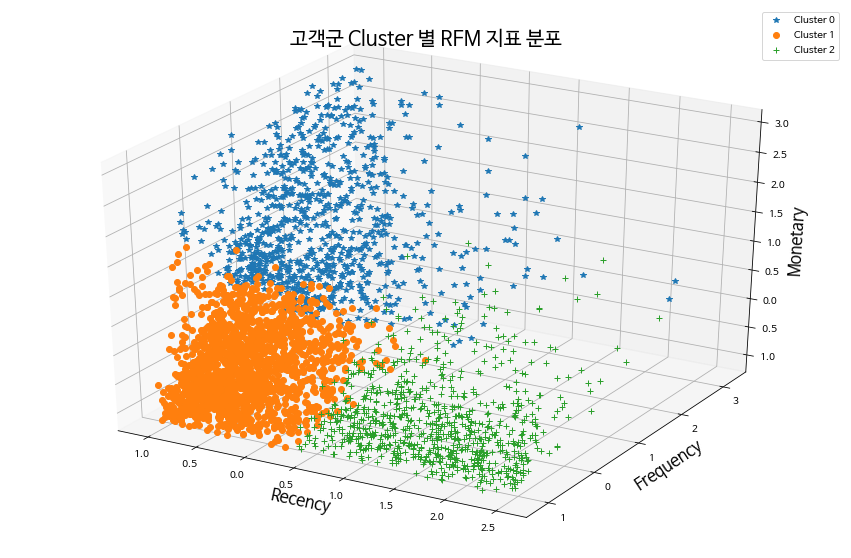

In [73]:
fig = plt.figure(figsize = (15, 10))


axes = plt.subplot(111, projection='3d')

axes.plot(cluster_0_recency, cluster_0_frequency, cluster_0_monetary, '*', label='Cluster 0')
axes.plot(cluster_1_recency, cluster_1_frequency, cluster_1_monetary, 'o', label='Cluster 1')
axes.plot(cluster_2_recency, cluster_2_frequency, cluster_2_monetary, '+', label='Cluster 2')
axes.set_xlabel('Recency', fontsize=16)
axes.set_ylabel('Frequency', fontsize=16)
axes.set_zlabel('Monetary', fontsize=16)
plt.title('고객군 Cluster 별 RFM 지표 분포', fontsize=20)

plt.legend(loc= 'upper right')
plt.show()

In [74]:
scatter_3d = px.scatter_3d(model_df_scaled, x='Recency', y='Frequency', z='Monetary',
              color='Cluster', symbol='Cluster')
scatter_3d.update_traces(marker_size = 3)
scatter_3d.update_layout(title_text = '고객군 Cluster 별 RFM 지표 분포')

pio.show(scatter_3d)

### 의사결정을 한다면?

각 고객층 별로 어떤 특징을 갖고 있는지 확인해봤습니다.

최종적으로 데이터에 기반해서 가상의 의사결정을 내려보겠습니다.

**휴면 고객**으로 분류되는 `Cluster 0` 고객층에게는 서비스 방문시

**"고객님! 다시 방문해주셔서 감사합니다 :) 이번 달 최초 구매 시 이후 n회 구매까지 할인 및 무료 배송 혜택을 누려보세요!"**

와 같은 메시지를 제공하여 고객 재활성화 및 최종 구매를 성사 시킬 수도 있겠습니다.

서비스 내 가장 높은 비율을 차지하는 `Cluster 1` 고객층은 우리 서비스를 이용한 적이 있으나 **서비스 이용율이 많이 낮은 그룹**입니다. 

해당 고객층에게는 다른 이커머스 플랫폼과 차별화된 우리 서비스의 메리트를 강조해 구매를 유도하고, 

주 고객층으로 전환될 수 있도록 하는 마케팅을 적용해 볼 수 있겠습니다.

`Cluster 2` 고객층은 **최근 구매 이력**이 있지만 구매 빈도수가 그렇게 높지 않은 고객층입니다.

`Cluster 2` 고객이 서비스를 이용할 경우, 최근에 구매한 물품을 구매했던 다른 고객들의 **구매 물품을 추천**해 주거나,

 **n회 이상 구매 시 추가 할인 혜택**과 같은 구매 유도 마케팅을 적용해 볼 수 있겠습니다.

## **결론 및 후기**

타깃으로 삼을 고객층을 **사전에 설정하는 것이 아닌**, 어떤 고객층을 타깃으로 삼을 것인지를 발견하기 위해 **비지도 학습**을 활용해보았습니다.

이렇게 비지도 학습을 통해 얻은 결과는 **우리가 알지 못했던 새로운 인사이트**를 주기도 한다는 것을 배웠습니다.

이렇게 나눠진 고객층별로 **각기 다른 목적과 전략을 활용한다면 높은 마케팅 효과**를 기대해 볼 수 있겠습니다.

----
더불어 이런 비지도 학습의 결과를 **'모든 각각의 데이터가 하나의 세그먼트에만 한정적으로 속해있다'** 라고 해석하면 안 되며, 


이를 효율적으로 사용할 방법을 지속해서 찾아야 할 것 같다고 느꼈습니다.

감사합니다.